In [66]:
from astropy.io import fits
from astropy.table import Table
import numpy as np
import scipy
from matplotlib import pyplot as plt

In [2]:
output_dir = '/media/hyz/dwarfcave/data/simulation/config_data/catalog'
SEED = 2030

# 前期尝试
给定宽度和亮度，生成背景上的星像

In [24]:
def get_mg(num):
    """get meshgird number. num must be type of numpy"""
    if num.size == 1:
        if num >= 0:
            return np.int16(num)
        if num < 0:
            return np.int16(num-1)
    elif num.size > 1:
        num[num>=0] = np.int16(num[num>=0])
        num[num<0] = np.int16(num[num<0]-1)
        num = np.int16(num)
        return num

def sample2density(mt):
    """from sample points to mesh distribution density.
    Only numpy.array with 2 dimension approval."""
    if mt.ndim == 2:
        _xmin,_xmax = get_mg(mt[:,0].min()), get_mg(mt[:,0].max())
        _ymin,_ymax = get_mg(mt[:,1].min()), get_mg(mt[:,1].max())
        _xgrid = np.arange(_xmin,_xmax,1)
        _ygrid = np.arange(_ymin,_ymax,1)
        mt = get_mg(mt)
        dens = np.zeros((_xgrid.size,_ygrid.size))
        for _xi,_xgi in enumerate(_xgrid):
            for _yi,_ygi in enumerate(_ygrid):
                dens[_xi,_yi] = np.sum((mt[:,0]==_xgi).reshape(-1,1) & 
                                       (mt[:,1]==_ygi).reshape(-1,1))
        return dens

def psf(width=10,lum=5):
    """psf model, default size is ten times by width"""
    
    s = width**2
    # 不怎么对的随机扭曲场效应
    np.random.seed(SEED)
    dt = np.random.rand(s,s)*0.01
    dt = np.ones_like(dt)+dt
    np.random.seed()
    
    # 不怎么对的天光背景
    bg = np.random.chisquare(10,(s,s))  # the first param can be realized as width
    
    # 光子模拟
    _size = np.int16(width*np.exp(lum/2))
    lg_x,lg_y = np.random.randn(1,_size) * width, np.random.randn(1,_size) * width
    lg = np.hstack(lg_x,lg_y)
    lg = sample2density(lg)
    _xnd, _ynd = lg.shape
    if _xnd > s:
        _d = _xnd-s
        lg = lg[_d//2:-(_d-_d//2),:]
    if _ynd > s:
        _d = _ynd-s
        lg = lg[:,_d//2:-(_d-_d//2)]
    _dx, _dy = s-_xnd, s-_ynd
    lg = np.pad(lg,((_dx//2,-(_dx-_dx//2)),(_dy//2,-(_dy-_dy//2))),
                'constant',constant_values=(0,0))
    
    # psf生成
    star = scipy.signal.convolve2d(lg,dt) + bg
    
    return star

In [222]:
unit_pixel_degree = 0.074/60/60

def star_clus(num):
    # 假设多星之间的分布是均匀随机的，假设每组框的尺寸为100*100pixel，坐标起点为0，0
    return np.array(np.random.rand(num,2)*\
            np.random.randint(0,100,num*2).reshape(num,2)*\
            unit_pixel_degree,dtype=np.float16)

def cat_g(point=[180,0],object='star',mode='num',num=5):
    """
    星表生成
    默认：指向icrs y轴，目标为星，模式为数字，每组混叠数为5，组间间距200pixel，因此9232*9216内共有2116组。
    """
    if object == 'star':
        # param need:
        # ra,dec,sourceID,g,model_tag,teff,grav,feh
        
        # 确认每组混叠数量
        if mode == 'num':
            num = np.ones((46,46),dtype=np.int8) * num  # 默认每组星数不超过127
        elif mode == 'random':
            # 假设每组混叠数为随机均匀分布，每组星数最小为2，最大为127
            num = np.random.randint(2,128,2116,dtype=np.int8).reshape((46,46))  
        else:
            print("error||  mode: num, random")
        
        # 每组初始坐标，为方便，坐标起点为0，0
        ax = np.arange(0,200*46,200)
        ax = np.array(np.meshgrid(ax,ax)).T
        ax = ax*unit_pixel_degree
        
        # 模拟混叠坐标，并得到每颗星的icrs位置
        #TODO: 限制数据格式以缩小文件大小
        sra_l,sdec_l = np.empty(0),np.empty(0)
        for _i,_x in enumerate(ax):
            for _j,_y in enumerate(ax[_i]):
                _c = ax[_i,_j]
                clus = star_clus(num[_i,_j])
                clus = point + clus + _c
                sra_l  = np.hstack((sra_l,clus[:,0]))
                sdec_l = np.hstack((sdec_l,clus[:,1]))
                
        # 模拟其他参数，假设其他参数与赤经赤纬位置的互相关系数为0
        nstar = sra_l.size
        id_l = np.arange(0,nstar,1)
        # 假设星数随星等的分布为exp
        mag = 25-np.random.exponential(5,nstar)
        tag = np.zeros(nstar)
        teff
        grav
        feh
                
        return sra_l

In [148]:
axis = np.arange(0,200*5,200)
ax = np.array(np.meshgrid(axis,axis)).T*unit_pixel_degree

(array([816.,  49.,  30.,  34.,   9.,  16.,  12.,  10.,  14.,  10.]),
 array([2.04654736e-19, 2.03974432e+13, 4.07948864e+13, 6.11923297e+13,
        8.15897729e+13, 1.01987216e+14, 1.22384659e+14, 1.42782103e+14,
        1.63179546e+14, 1.83576989e+14, 2.03974432e+14]),
 <BarContainer object of 10 artists>)

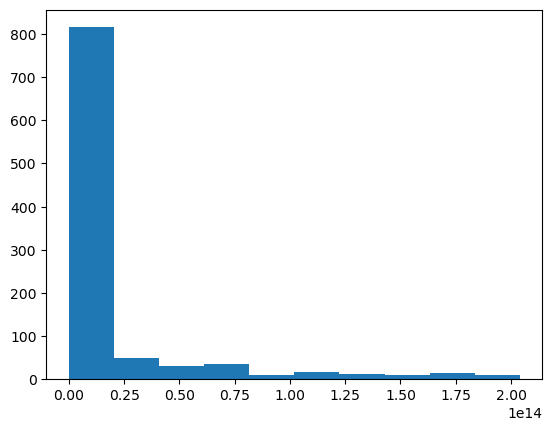

In [233]:

plt.hist(np.power(np.random.rand(1000)*32-5,10))

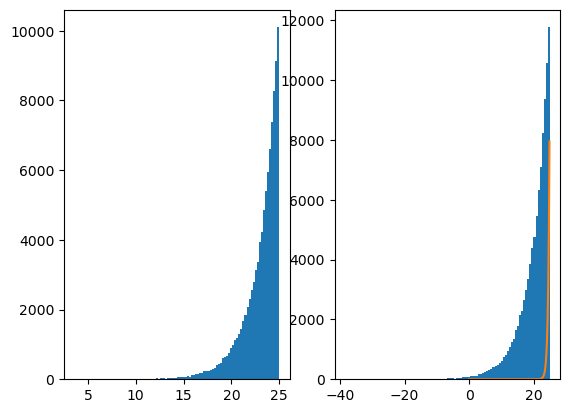

In [256]:
plt.subplot(121)
plt.xlim=(0,20)
plt.hist(25-np.random.exponential(2,100000),bins=100)
plt.subplot(122)

plt.hist(25-np.random.exponential(5,100000),bins=100)
plt.xlim=(0,20)
plt.plot(np.arange(0,25,0.1),10**np.arange(0,25,0.1)*1e-21)

# 简单星表生成
（用于测试仿真代码是否有效）

In [1]:
import numpy as np
from astropy.io import fits
from astropy.table import Table

n_star = 10000000
ra = np.random.rand(n_star)*2 + 55
dec = np.random.rand(n_star)*2 + 40
g = np.random.rand(n_star)*20 + 7
# model_tag = np.zeros_like(g)
teff = np.random.rand(n_star)*4000 + 3000       # 有效温度：3000-7000K
grav = np.random.rand(n_star)*2 + 3             # 表面重力：3-5
feh_sdisk = np.random.rand(int(n_star*0.7))*3.5 - 3.5           # 金属丰度：薄盘-3.5~0
feh_ldisk = np.random.rand(n_star-int(n_star*0.7))*1.5 - 1      #         厚盘-1~0.5
feh = np.hstack((feh_ldisk,feh_sdisk))
pmra = np.zeros_like(g)
pmdec = np.zeros_like(g)
rv = np.zeros_like(g)
parallax = np.ones_like(g)*1e-9
t = Table([ra,dec,g,teff,grav,feh,pmra,pmdec,rv,parallax],
          names=('RA','Dec','app_sdss_g','teff','grav','feh','pmra','pmdec','RV','parallax'))
# t.write('/media/hyz/dwarfcave/data/csst_simulation_dir/data_dir/catalog/simple_test.fits', format='fits',overwrite=True)
t.write('/home/haoyanzhen_shao/project/simulation_work/data_dir/catalog/starnum_test.fits', format='fits',overwrite=True)

In [ ]:
from cat2hdf5 import fits_to_hdf5 as f2h
f2h("/home/haoyanzhen_shao/project/simulation_work/data_dir/catalog/starnum_test.fits",
    "/home/haoyanzhen_shao/project/simulation_work/data_dir/catalog/starnum_test.hdf5")


检查cat

In [ ]:
rhdu = fits.open('tabel.fits')
rdata = rhdu[1].data
rdata.columns.names

检查hdf5中的model_tag

In [58]:
import h5py as h5

ds = h5.File('/home/haoyanzhen_shao/project/simulation_work/config/catalog/simple_test.hdf5','r')['catalog']

In [77]:
ds.keys()

<KeysViewHDF5 ['32081', '32082', '32083', '32084', '32590', '32591', '32592', '32593', '33102', '33103', '33104', '33105', '33614', '33615', '33616', '33617', '34126', '34127', '34128', '34129', '34638', '34639', '34640', '34641', '35150', '35151', '35152', '35153']>

In [ ]:
ds['33614']['model_tag'][:]

检查生成的cat星表

In [87]:
import os

cat_path = '/home/haoyanzhen_shao/project/simulation_work/work_dir/CrowdedField20230209/MSC_0000000/MSC_100000000_chip_06_filt_y.cat'
with open(cat_path) as cat:
    catll = cat.readlines()
    len_cat = len(catll)
    xi,yi = [],[]
    for l in catll[1:]:
        l = l.split(' ')
        xi.append(l[3])
        yi.append(l[4])
        
    erg_name = cat_path[:-4] + '.erg'
    with open(erg_name,'w') as erg:
        erg.writelines("# Region file format: DS9 version 4.1\nglobal color=blue dashlist=8 3 width=1 font='helvetica 10 normal roman' select=1 highlite=1 dash=0 fixed=0 edit=1 move=1 delete=1 include=1 source=1\nimage\n")
        for i in range(catll):
            erg.writelines("circle(" + str(xi[i]) + "," + str(yi[i]) + ")\n")


'MSC_100000000_chip_06_filt_y.erg'

# 符合银河系分布的星表生成
- g波段光度 假设服从指数分布
- 有效温度  假设服从指数分布
- 表面重力  假设服从与teff的线性分布+随机偏移
- 金属丰度  假设薄盘和厚盘分别服从chi2和正态分布

In [1]:
from scipy import stats
import numpy as np
from matplotlib import pyplot as plt
from astropy.table import Table

# n_star = int(1e9)  # 1e9-30deg
n_star = int(3e8)   # 3e8-27deg
#  image_rotation: -113.4333
ra = np.random.rand(n_star)*1.4 + 270.3
dec = np.random.rand(n_star)*1.4 - 41.7
# x = np.arange(0,30,0.1)
# plt.plot(x,np.log(stats.expon.pdf(10-x,loc=-4,scale=16/6))+3-np.log(stats.expon.pdf(10-4,loc=-4,scale=16/6))) # distribution can be used
# plt.hist(0-stats.expon.rvs(size=10000,loc=-30,scale=16/6),bins=100)
# g = 0-stats.expon.rvs(size=n_star,loc=-30,scale=16/6)
g = 0-stats.expon.rvs(size=n_star,loc=-27,scale=16/6)
teff = stats.expon.rvs(size=n_star,loc=2500,scale=18000/10)
grav = np.random.rand(n_star) + 3.6
feh_thindisk = stats.chi2.rvs(size=int(n_star*0.8),loc=-0.6,scale=0.1,df=3)
feh_thickdisk = stats.norm.rvs(size=n_star-int(n_star*0.8),loc=-0.7,scale=0.25)
feh = np.hstack((feh_thindisk,feh_thickdisk))
pmra = np.zeros_like(g)
pmdec = np.zeros_like(g)
rv = np.zeros_like(g)
parallax = np.ones_like(g)*1e-9
t = Table([ra,dec,g,teff,grav,feh,pmra,pmdec,rv,parallax],
          names=('RA','Dec','app_sdss_g','teff','grav','feh','pmra','pmdec','RV','parallax'))
t.write('/home/haoyanzhen_shao/project/simulation_work/data_dir/catalog/crowdedField_test0219_g27_3e8.fits', format='fits',overwrite=True)

In [2]:
from self_test.cat2hdf5 import fits_to_hdf5 as f2h
f2h("/home/haoyanzhen_shao/project/simulation_work/data_dir/catalog/crowdedField_test0219_g27_3e8.fits",
    "/home/haoyanzhen_shao/project/simulation_work/data_dir/catalog/crowdedField_test0219_g27_3e8.hdf5")


convertion succ


In [4]:
1e7 * (1.4*1.4) / (9232*9216*0.074*0.074/3600/3600)

545204424.4112959

In [6]:
t

RA,Dec,app_sdss_g,teff,grav,feh,pmra,pmdec,RV,parallax
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
271.2738701908863,-40.915641362943255,29.409225296247392,3531.225188835897,4.2822454252424516,-0.5634834058730375,0.0,0.0,0.0,1e-09
270.46000383637346,-40.23125686221161,24.337191679347328,2717.75921686486,4.340838153033536,-0.509408065356446,0.0,0.0,0.0,1e-09
270.94462017205393,-41.300166255958274,29.484918406407434,4288.295809273478,3.766696640726796,0.42744764901758014,0.0,0.0,0.0,1e-09
271.51843890088253,-41.809068412433426,29.8242833638668,3768.648020407086,3.842945840126294,0.49282322025633507,0.0,0.0,0.0,1e-09
270.3891560721649,-41.52999373601711,26.600385399005212,3911.2601345052726,4.0406044687825275,0.017443270988205195,0.0,0.0,0.0,1e-09
270.74530168154746,-41.47509292859977,27.30594651816732,4761.125059470345,4.041265423089221,-0.3222903901471645,0.0,0.0,0.0,1e-09
271.39697337506857,-40.76083147056229,29.976059272464717,3047.2721273120833,4.313383989888663,-0.3517796266601928,0.0,0.0,0.0,1e-09
270.2284369035602,-40.36061503851274,25.887044781441553,3380.808929200244,4.066587042995753,-0.31916387188203527,0.0,0.0,0.0,1e-09
270.362334078913,-40.50413404750925,29.781041172367814,5566.065102068052,3.9782786520304327,0.036597373148243406,0.0,0.0,0.0,1e-09


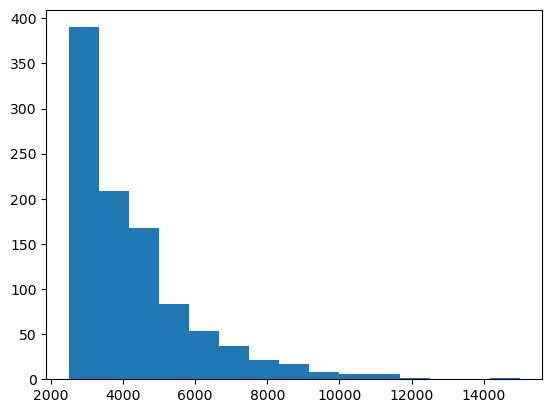

In [5]:
from matplotlib import pyplot as plt
from scipy import stats

plt.hist(stats.expon.rvs(size=1000,loc=2500,scale=18000/10),bins=15)
s=1

In [4]:
import h5py as h5
f = h5.File('/home/haoyanzhen_shao/project/simulation_work/data_dir/catalog/crowdedField_test0215.hdf5','r')['catalog']
f.keys()

<KeysViewHDF5 ['161408', '161409', '161410', '161411', '161920', '161921', '161922', '162432', '162433', '162434', '162435', '162944', '162945', '162946', '163456', '163457', '163458', '163459', '163968', '163969', '163970', '164477', '164478', '164479']>

# 根据Shao Zhengyi的星表拟合进行的星表再生成
见catalog_sampler.ipynb

# 制作用于多星表合并的仿真星表
- 恒星星表：CSST_trilegal和Gaia转换到J2000时刻的恒星星表结合
- 星系星表：cosmoDC2

## 预设置

In [1]:
ra = 81.5625
dec = -31.38816646
radius = 1.1

## 天区指向文件

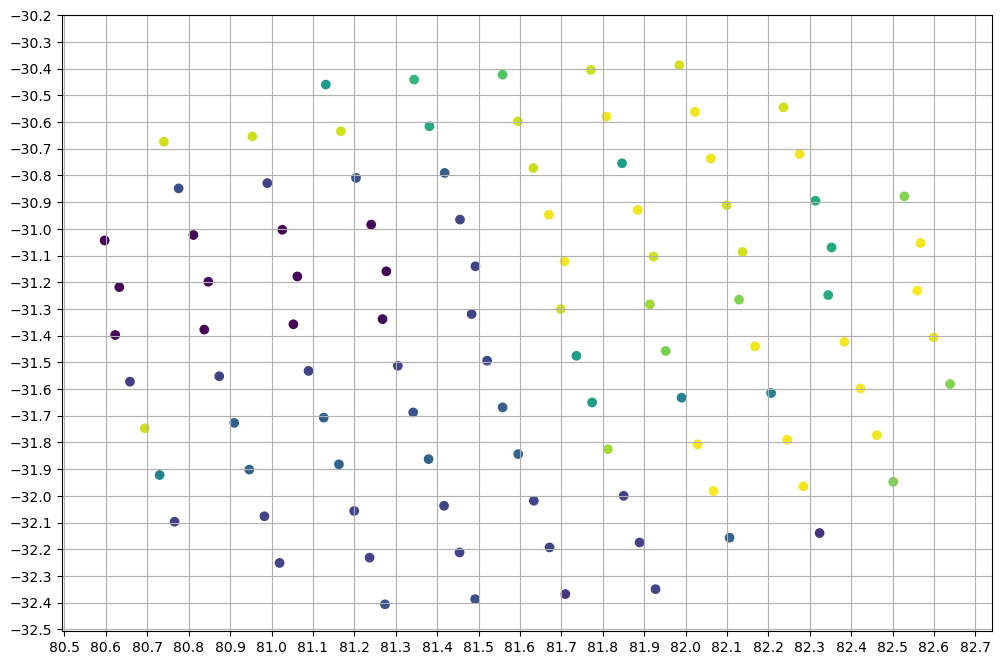

In [2]:
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.table import Table
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt


# 读取指向文件
with open('/home/haoyanzhen_shao/project/simulation_work/pointing/pointing_20220503_WL_2.5yr_tA_60_ML_1.0yr_tA_90_9deg2_tA_80_post.dat','r') as f:
    names = f.readlines()[0].strip()[1:].split(' ')[1:]
pointing = pd.read_csv('/home/haoyanzhen_shao/project/simulation_work/pointing/pointing_20220503_WL_2.5yr_tA_60_ML_1.0yr_tA_90_9deg2_tA_80_post.dat',names=names,sep=' ',comment='#')
pointing

selection = pointing[(pointing['ra']-ra)**2+(pointing['dec']-dec)**2<1.1**2]

plt.figure(figsize=(12,8))
plt.scatter(selection['ra'],selection['dec'],c=selection['time(julian)'])
plt.xticks(np.linspace(80.50,82.70,23))
plt.yticks(np.linspace(-32.5,-30.2,24))
plt.grid()

时间跨度（年）：  7.95816968416489


,ra,dec,gall,galb,lon(ecliptic),lat(ecliptic),pos_angle,time(julian),sat_x,sat_y,...,sun_y,sun_z,moon_x,moon_y,moon_z,sat_vx,sat_vy,sat_vz,exp_time,isDeep
21996,81.268189,-31.337968,234.850210,-31.122762,77.1429,-54.3898,-113.4333,2.459844e+06,-2742.3344,6016.0815,...,3.480217e+06,1.510020e+06,-267416.0417,258658.3807,151251.1658,-4.815909,-3.358949,-4.951685,150.5530,-1.0
139667,81.483405,-31.319061,234.883974,-30.940233,77.4603,-54.3898,-113.4333,2.460406e+06,-4084.2938,4211.6043,...,3.795361e+07,1.645116e+07,322101.9946,-142102.1942,-86221.6780,-6.077352,-3.058752,3.542932,150.0000,-1.0
531489,81.913945,-31.282649,234.953992,-30.575490,78.0952,-54.3898,-113.4333,2.462381e+06,-3057.3931,5580.4412,...,4.880723e+07,2.115758e+07,82879.8743,352480.6294,161979.0343,-4.498889,-4.281040,-4.527810,150.4513,-1.0
553019,81.698702,-31.300618,234.918577,-30.757770,77.7778,-54.3898,-113.4333,2.462598e+06,4442.1381,4596.8360,...,3.784750e+07,1.640495e+07,250044.6786,286303.0625,141158.0514,-3.177640,5.262571,4.606147,150.3949,-1.0
213151,81.558258,-31.668694,235.297135,-30.968080,77.5089,-54.7441,-113.4333,2.460705e+06,-5929.1849,1941.6693,...,-1.038666e+08,-4.502559e+07,256805.3122,-238238.9692,-128742.1560,-3.614064,-5.249673,4.277028,150.0000,-1.0
289088,81.990517,-31.632288,235.365936,-30.603071,78.1495,-54.7441,-113.4333,2.461125e+06,-5660.3542,1354.5873,...,1.110689e+07,4.814140e+06,-18619.7849,326500.1783,175085.7374,-3.498349,-5.904620,3.433152,150.0000,-1.0
369351,81.774381,-31.650253,235.331116,-30.785513,77.8292,-54.7441,-113.4333,2.461468e+06,-6119.8906,1236.1004,...,-4.102999e+07,-1.778673e+07,137165.7176,-341850.3809,-168661.1614,0.533445,-6.344961,-4.304022,150.0000,-1.0
553020,81.922571,-31.103927,234.755934,-30.521610,78.1371,-54.2126,-113.4333,2.462598e+06,3704.4710,5515.5757,...,3.785273e+07,1.640722e+07,249894.8044,286419.1188,141191.6704,-4.227237,3.959675,5.047903,150.1346,-1.0
577844,81.707477,-31.121820,234.719997,-30.704026,77.8207,-54.2126,-113.4333,2.462749e+06,975.5194,6468.5347,...,4.347216e+07,1.884477e+07,-140195.4263,-313222.2897,-138026.3979,-5.961725,-0.371575,-4.831806,150.0000,-1.0


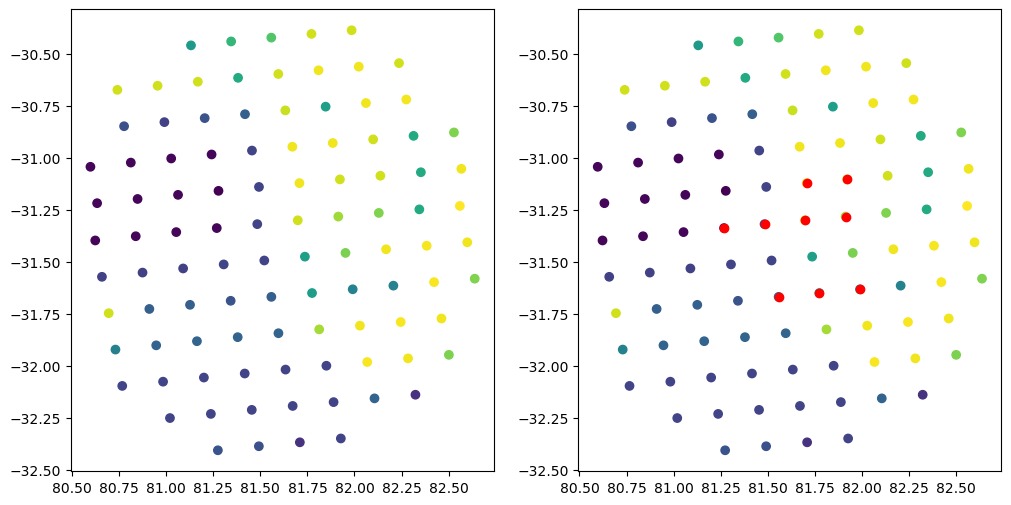

In [5]:
xx = selection[(selection['ra']<82.)&(selection['ra']>81.2)&(selection['dec']<-31.2)&(selection['dec']>-31.4)]
xx2 = selection[(selection['ra']<82)&(selection['ra']>81.5)&(selection['dec']<-31.6)&(selection['dec']>-31.7)]
xx = pd.concat([xx,xx2])
xx3 = selection[(selection['ra']<82)&(selection['ra']>81.6)&(selection['dec']<-31.0)&(selection['dec']>-31.2)]
xx = pd.concat([xx,xx3])
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.scatter(selection['ra'],selection['dec'],c=selection['time(julian)'])
plt.subplot(122)
plt.scatter(selection['ra'],selection['dec'],c=selection['time(julian)'])
plt.scatter(xx['ra'],xx['dec'],c='r')
print('时间跨度（年）： ',(xx['time(julian)'].max()-xx['time(julian)'].min())/365)
xx

In [6]:
names = ['ra','dec','lon(ecliptic)','lat(ecliptic)','pos_angle','time(julian)',
                         'sat_x','sat_y','sat_z','sun_x','sun_y','sun_z','moon_x','moon_y','moon_z',
                        'sat_vx','sat_vy','sat_vz','exp_time','isDeep']
definition = xx[names]

difinition_path = '/home/haoyanzhen_shao/project/simulation_work/pointing/pointing_for_catcombined_20230608p.dat'
with open(difinition_path,'w') as f:
    f.write('# ')
    # with open('/home/haoyanzhen_shao/project/simulation_work/pointing/pointing_20220503_WL_2.5yr_tA_60_ML_1.0yr_tA_90_9deg2_tA_80_post.dat','r') as f2:
    #     names = f2.readlines()[0].strip()[1:].split(' ')[1:]
    for i in names:
        f.write(i)
        f.write(' ')
    f.write('\n')
definition.to_csv(difinition_path,sep=' ',index=False,header=False,mode='a')

## 恒星星表

In [2]:
from self_test.cat2hdf5 import fits_to_hdf5 as f2h
f2h('/home/haoyanzhen_shao/project/simulation_work/data_dir/catalog/selection_merge20230609_merge_forsim.fits',
    '/home/haoyanzhen_shao/project/simulation_work/data_dir/catalog/selection_merge20230609_merge_forsim.hdf5')


2.13772281967317 2.0994826828384974 1.442687428662335 1.404349584739388
convertion succ


## 星系星表

In [8]:
import healpy as hp

nside = 32
hp.nside2npix(nside),360*180/hp.nside2npix(nside)

(12288, 5.2734375)

In [9]:
import h5py as h5

gal = h5.File('/home/haoyanzhen_shao/project/simulation_work/data_dir/cosmoDC2/z_0_1.step_all.healpix_8792.hdf5')

param_need = ['ra_true','dec_true','mag_true_g_lsst','redshift_true',
              'hlr_disk','hlr_bulge',
              'ell_disk','ell_bulge','ell_tot',
              'sersic_disk','sersic_bulge',
              'bulge_to_total_ratio_i','position_angle_true',
              'galaxyID']
# 注： sersic指数默认为盘1，球4
gal['galaxyProperties'].keys(),gal['galaxyProperties/morphology'].keys(),gal['galaxyProperties/LSST_filters'].keys()

(<KeysViewHDF5 ['LSST_filters', 'SDSS_filters', 'SEDs', 'baseDC2', 'blackHoleAccretionRate', 'blackHoleEddingtonRatio', 'blackHoleMass', 'convergence', 'dec', 'dec_true', 'diskAbundancesStellarMetals', 'diskMassStellar', 'diskStarFormationRate', 'diskVelocity', 'emissionLines', 'galaxyID', 'hostHaloMass', 'hostHaloTag', 'infallIndex', 'isCentral', 'lightcone_replication', 'lightcone_rotation', 'magnification', 'matchUp', 'morphology', 'otherLuminosities', 'peculiarVelocity', 'ra', 'ra_true', 'redshift', 'redshiftHubble', 'shear1', 'shear2', 'spheroidAbundancesStellarMetals', 'spheroidMassStellar', 'spheroidStarFormationRate', 'spheroidVelocity', 'spinSpin', 'step', 'totalAbundancesStellarMetals', 'totalMassStellar', 'totalStarFormationRate', 'totalVelocity', 'uniqueHaloID', 'vx', 'vy', 'vz', 'x', 'y', 'z']>,
 <KeysViewHDF5 ['diskAxisRatio', 'diskEllipticity', 'diskEllipticity1', 'diskEllipticity2', 'diskHalfLightRadius', 'diskHalfLightRadiusArcsec', 'diskMajorAxisArcsec', 'diskMinorAxi

In [10]:
param_exits = ['ra_true', 'dec_true', 'LSST_filters/magnitude:LSST_g:observed','redshift',
               'morphology/diskHalfLightRadius','morphology/spheroidHalfLightRadius',
               'morphology/diskEllipticity','morphology/spheroidEllipticity','morphology/totalEllipticity',
               'morphology/diskSersicIndex','morphology/spheroidSersicIndex',
               'morphology/spheroidAxisRatio','morphology/positionAngle',
               'galaxyID']

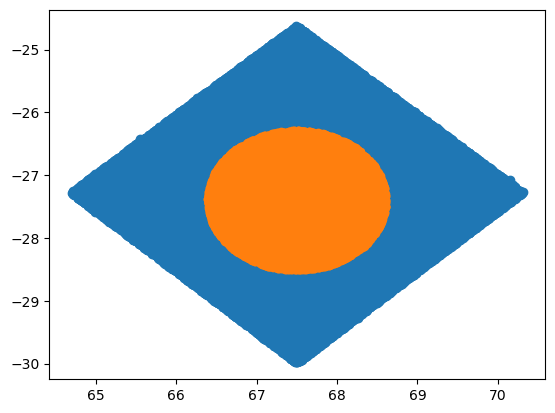

In [11]:
import h5py as h5
import matplotlib.pyplot as plt
import numpy as np

gal_ra, gal_dec, circle_ra, circle_dec = np.empty(0),np.empty(0),np.empty(0),np.empty(0)
for ipix in [8792,8919,8920,9048]:
    gal = h5.File(f'/home/haoyanzhen_shao/project/simulation_work/data_dir/cosmoDC2/z_0_1.step_all.healpix_{ipix}.hdf5','r')
    gal_ra = np.concatenate([gal_ra,gal['galaxyProperties/ra_true'][:]])
    gal_dec = np.concatenate([gal_dec,gal['galaxyProperties/dec_true'][:]])
circle_slice = (gal_ra-67.5)**2+(gal_dec+27.4)**2 < 1.1**2
circle_ra = gal_ra[circle_slice]
circle_dec = gal_dec[circle_slice]
plt.scatter(gal_ra[::100],gal_dec[::100])
plt.scatter(circle_ra[::100],circle_dec[::100])

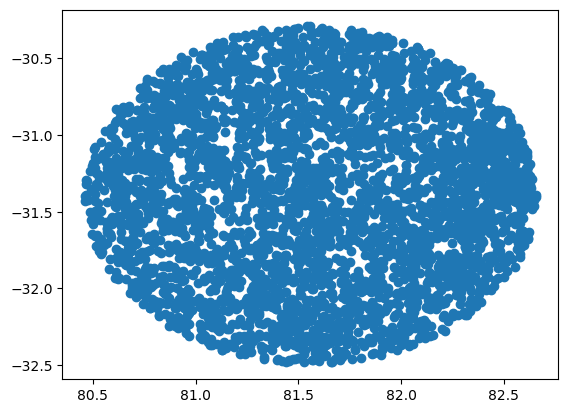

In [13]:
import h5py as h5
import matplotlib.pyplot as plt
import numpy as np


# 生成包含所有所需参数的变量，并包含入gal_data中
gal_data = []
for p in param_need:
    vars()[p] = np.empty(0)
    gal_data.append(vars()[p])

# 提取数据
for ipix in [8792,8919,8920,9048]:
    for z in ['0_1','1_2','2_3']:
        gal = h5.File(f'/home/haoyanzhen_shao/project/simulation_work/data_dir/cosmoDC2/z_{z}.step_all.healpix_{ipix}.hdf5','r')
        gal = gal['galaxyProperties']
        for (ip, p) in enumerate(param_need):
            # 限制21星等
            _slice = np.where(gal['LSST_filters/magnitude:LSST_g:observed'][:]<21)
            gal_data[ip] = np.concatenate([gal_data[ip],gal[param_exits[ip]][_slice]])
        
# 获取空间索引
circle_slice = (gal_data[0]-67.5)**2+(gal_data[1]+27.4)**2 < radius**2

# 创建空文件并写入变量
with h5.File('/home/haoyanzhen_shao/project/simulation_work/data_dir/catalog/fromcosmoDC2_radius1.1_maglt21.hdf5', 'w') as target:
    target.create_group('galaxies')
    for (ip, p) in enumerate(param_need):
        if p == 'ra_true':
            target['galaxies'].create_dataset(name=p, data=gal_data[ip][circle_slice]-(67.5-ra))
        elif p == 'dec_true':
            target['galaxies'].create_dataset(name=p, data=gal_data[ip][circle_slice]-(-27.4-dec))
        else:
            target['galaxies'].create_dataset(name=p, data=gal_data[ip][circle_slice])
    plt.scatter(target['galaxies/ra_true'],target['galaxies/dec_true'])

## 检查

In [1]:
import h5py as h5
import numpy as np

stars = h5.File('/home/haoyanzhen_shao/project/simulation_work/data_dir/catalog/selection_merge20230609_merge_forsim.hdf5','r')

gals = h5.File('/home/haoyanzhen_shao/project/simulation_work/data_dir/catalog/fromcosmoDC2_radius1.1_maglt21.hdf5','r')
gals = gals['galaxies']

star_ra,star_dec = np.empty(0),np.empty(0)
for ipix in stars['catalog'].keys():
    star_ra = np.concatenate([star_ra,stars['catalog'][ipix]['RA'][:]])
    star_dec = np.concatenate([star_dec,stars['catalog'][ipix]['Dec'][:]])


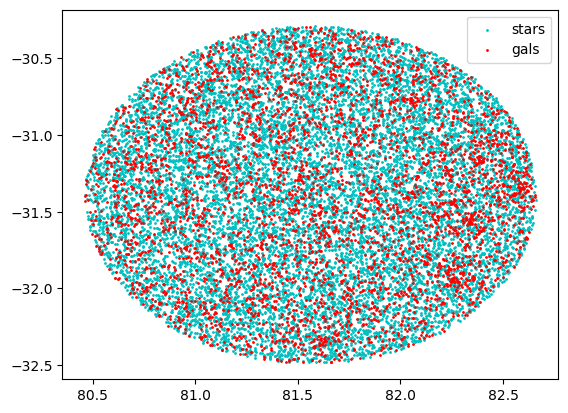

In [11]:
import matplotlib.pyplot as plt

plt.scatter(star_ra,star_dec,s=1,c='c',label='stars')
plt.scatter(gals['ra_true'],gals['dec_true'],s=1,c='r',label='gals')
plt.legend()

In [12]:
len(gals['ra_true']), len(star_ra)

(4253, 12865)

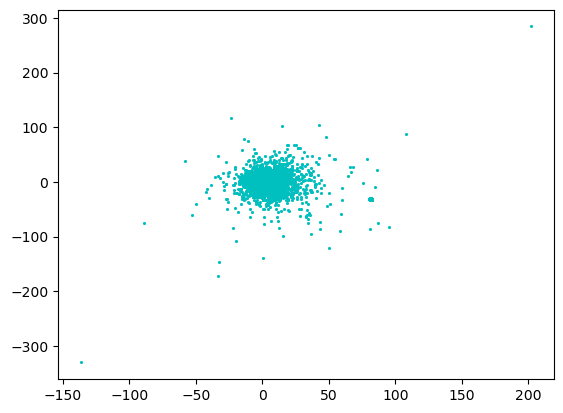

In [22]:
star_pmra,star_pmdec = np.empty(0),np.empty(0)
for ipix in stars['catalog'].keys():
    star_pmra = np.concatenate([star_ra,stars['catalog'][ipix]['pmra'][:]])
    star_pmdec = np.concatenate([star_dec,stars['catalog'][ipix]['pmdec'][:]])
plt.scatter(star_pmra,star_pmdec,s=1,c='c',label='stars')

In [15]:
len(star_pmra)

0

In [20]:
stars['catalog']['147828']['pmra']

<HDF5 dataset "pmra": shape (542,), type ">f8">

In [2]:
gals.keys()

<KeysViewHDF5 ['bulge_to_total_ratio_i', 'dec_true', 'ell_bulge', 'ell_disk', 'ell_tot', 'galaxyID', 'hlr_bulge', 'hlr_disk', 'mag_true_g_lsst', 'position_angle_true', 'ra_true', 'redshift_true', 'sersic_bulge', 'sersic_disk']>